In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/data-sma/4_detail_table_depots.xls
/kaggle/input/data-sma/3_detail_table_vehicles.xls
/kaggle/input/data-sma/1_master_table_route_settings.xls
/kaggle/input/data-sma/9_table_blocked_parts_of_the_road.xls
/kaggle/input/data-sma/8_detail_table_routes_RESULTS.xls
/kaggle/input/data-sma/2_detail_table_customers.xls
/kaggle/input/data-sma/5_detail_table_constraints_sdvrp.xls
/kaggle/input/data-sma/6_detail_table_cust_depots_distances.xls
/kaggle/input/data-sma/7_detail_table_cust_cust_distances.xls


In [2]:
pip install xlrd


Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install mesa

Note: you may need to restart the kernel to use updated packages.


In [4]:
from mesa import Agent
from mesa import Model
from mesa.time import BaseScheduler
from mesa.datacollection import DataCollector
import random as rd
import numpy as np
import pandas as pd
import numpy as np
import random as rd
import numpy as np


cost_depot_customers = pd.read_excel(r"/kaggle/input/data-sma/6_detail_table_cust_depots_distances.xls")
cost_customers_customers = pd.read_excel(r"/kaggle/input/data-sma/7_detail_table_cust_cust_distances.xls")
trucks_infos = pd.read_excel(r"/kaggle/input/data-sma/3_detail_table_vehicles.xls")
depot_infos= pd.read_excel(r"/kaggle/input/data-sma/4_detail_table_depots.xls")
customers_list = pd.read_excel(r"/kaggle/input/data-sma/2_detail_table_customers.xls")
road_choice = 2922001

###############################################################################
#################################   Classes   #################################
###############################################################################

class Client:

    def __init__(self, name, x, y, quantity, start, stop,code):
        self.name = name
        self.code = code
        self.x = x
        self.y = y
        self.quantity = quantity
        self.start = start
        self.stop = stop
        self.delivered = False

class Truck:
    
    def __init__(self, name, quantity_max, start, stop,route_id):
        self.name = name
        self.route_id = route_id
        self.x = 0
        self.y = 0
        self.quantity_max = quantity_max
        self.start = start
        self.stop = stop
        self.remaining_quantity=quantity_max
        self.P = [0]
        self.cost = 0
        self.time = 0

    def delivery(self, client):
        self.x=client.x
        self.y=client.y
        self.remaining_quantity -= client.quantity
        
    def calculate_cost(self, data,listOfClients):
        self.cost=0
        self.time=0
        self.remaining_quantity=self.quantity_max
        demande = 0
        weight_K = 10000
        weight_q = 10000
        weight_t = 3
        weight_d = 13
        weight_c = 10     
        for m in range(len(self.P)):
            demande += listOfClients[m].quantity
        self.remaining_quantity-=demande
        if(self.remaining_quantity<0):
            self.cost+=(self.remaining_quantity*(-1))*weight_q
        for i in range (len(self.P)-1):
            self.cost += (distanceTab(self.P[i],self.P[i+1],listOfClients)*weight_c)
            self.time += data[self.P[i]][self.P[i+1]]
            if self.time <= listOfClients[self.P[i+1]].start:
                self.cost += ((listOfClients[self.P[i+1]].start - self.time)*weight_t)
                self.time = listOfClients[self.P[i+1]].start
            if self.time >= listOfClients[self.P[i+1]].stop:
                self.cost += ((self.time - listOfClients[self.P[i+1]].stop)*weight_d)
        self.cost += weight_K
        return (self.cost)
        

           


def distanceTab(C1, C2, listOfClients):
        return(np.sqrt((listOfClients[C1].y-listOfClients[C2].y)**2 + (listOfClients[C1].x - listOfClients[C2].x)**2))
    


def find_client_by_code(code,liste_clients):
    find = False
    i=0
    client = Client(-1,-1,-1,-1,-1,-1,-1)
    while i<len(liste_clients) and not find :
        if liste_clients[i].code == code :
            client = liste_clients[i]
            find = True
        i +=1
    return client


def cost_matrix(liste_clients,cost_depot_customers,cost_customers_customers):
    n = len(liste_clients)+1
    cost_matrix= np.zeros((n,n))
    time_matrix= np.zeros((n,n))
    for i in range(0,len(cost_depot_customers),2):
        client = find_client_by_code(cost_depot_customers['CUSTOMER_CODE'][i],liste_clients)
        if client.name == -1 :
            pass
        else : 
            cost_matrix[0][client.name+1] = cost_depot_customers['DISTANCE_KM'][i]
            cost_matrix[client.name+1][0] = cost_depot_customers['DISTANCE_KM'][i+1]
            time_matrix[0][client.name+1] = cost_depot_customers['TIME_DISTANCE_MIN'][i]
            time_matrix[client.name+1][0] = cost_depot_customers['TIME_DISTANCE_MIN'][i+1]
    for i in range(len(cost_customers_customers)):
        client_1=find_client_by_code(cost_customers_customers['CUSTOMER_CODE_FROM'][i],liste_clients)
        client_2=find_client_by_code(cost_customers_customers['CUSTOMER_CODE_TO'][i],liste_clients)
        if client_1.name == -1 or client_2.name==-1 : 
            pass
        else : 
            cost_matrix[client_1.name+1][client_2.name+1] = cost_customers_customers['DISTANCE_KM'][i]
            time_matrix[client_1.name+1][client_2.name+1] = cost_customers_customers['TIME_DISTANCE_MIN'][i]
    return cost_matrix,time_matrix

def liste_c(customers_list):
    liste_clients = []
    for i in range(len(customers_list)):
        customer = Client(i,customers_list['CUSTOMER_LATITUDE'][i],customers_list['CUSTOMER_LONGITUDE'][i],
                        customers_list['CUSTOMER_TIME_WINDOW_FROM_MIN'][i],customers_list['CUSTOMER_TIME_WINDOW_TO_MIN'][i],customers_list['TOTAL_VOLUME_M3'][i],
                        customers_list['CUSTOMER_CODE'][i])
        liste_clients.append(customer)
    return liste_clients

def liste_tr(trucks_infos,depot_infos):
    lat = depot_infos['DEPOT_LATITUDE'][0]
    long = depot_infos['DEPOT_LONGITUDE'][0]
    T = []
    for i in range(len(trucks_infos)):
        T.append(Truck(i,trucks_infos['VEHICLE_TOTAL_VOLUME_M3'][i],lat,long,trucks_infos['ROUTE_ID'][i]))
    return T


def truncate_df(df,road_choice):
    minimum = df.ROUTE_ID.eq(road_choice).idxmax()
    df = df.truncate(before = minimum)
    maximum = df.ROUTE_ID.ne(road_choice).idxmax()-1
    df = df.truncate(after=maximum)
    df.reset_index(drop=True,inplace=True)
    return df

cost_customers_customers=truncate_df(cost_customers_customers,road_choice)
cost_depot_customers=truncate_df(cost_depot_customers,road_choice)
trucks_infos=truncate_df(trucks_infos,road_choice)
customers_list=truncate_df(customers_list,road_choice)
depot_infos = truncate_df(depot_infos,road_choice)

depot=Client(-1,depot_infos['DEPOT_LATITUDE'][0],depot_infos['DEPOT_LONGITUDE'][0],0,0,0,-100000)

list_clients = liste_c(customers_list)
clients= [[list_clients[i].quantity, list_clients[i].start, list_clients[i].stop] for i in range(len(list_clients))]
trucks_list = liste_tr(trucks_infos,depot_infos)
n_trucks = len(trucks_list)
(c_matrix,t_matrix)=cost_matrix(list_clients,cost_depot_customers,cost_customers_customers)


###############################################################################
######################   Enregistrement des constantes   ######################
###############################################################################
T = liste_tr(trucks_infos,depot_infos)
n_trucks = len(T) #Nombre de camions
truck_capacity = [ i.quantity_max for i in T] #Capacité unitaire pouvant être emmenée par chaque camion
time_matrix = t_matrix

#Paramètres AGs
nb_pop = 100 #taille de notre population
nb_generations = 200 #nombre de générations étudiées par l'AGs
elitism = True #Volonté de ne sélectionner que les meilleurs éléments
best_pop = 40 #Taille de la population élite : les N-meilleurs membres de la population
mutation_rate = 0.4 #probabilité de mutation lors du passage à la génération suivante

weight_K=10_000
weight_q=10_000
weight_t=3
weight_d=13
weight_c=10

###############################################################################
##########################   Fonctions d'évaluation  ##########################
###############################################################################



def track_evaluation(truck_track):
    truck_track = closing_tour(truck_track)
    t3=0
    trucks_time = []
    for track in truck_track:
        t=0
        for q in truck_capacity :
            
            if len(track) >2 :
                t3+= weight_K*len(truck_capacity) #Si le camion est utilisé, ajout du coût d'utilisation dans le score du circuit
            for i in range(1,len(track)):
                
                # Evaluation fenêtre
                t2= time_matrix[track[i-1]][track[i]]
                
                t4 = c_matrix[track[i-1]][track[i]]
                if t+t2 <= clients[track[i]][1]: #Si arrivé du livreur avant la fin de la fenêtre
                    t+=t4 * weight_c
                    t3 +=  max(0,clients[track[i]][0]-t) * weight_t
                    t+=+max(0,clients[track[i]][0]-t)  #ajout d'un temps d'attente si le livreur arrive avant le début de la fenêtre
                else :
                    t3+= (t+t2 - clients[track[i]][1])*weight_d #ajout d'une pénalité si une fenêtre n'est pas respectée
                    t+=t4*weight_c
                  
                # Evaluation quantité            
                if q >= clients[track[i]][2]:
                    q-=clients[track[i]][2]
                else : 
                    t3+=(clients[track[i]][2]-q)*weight_q   #ajout d'une pénalité si une quantité n'est pas respectée
                    q=0                
        trucks_time.append(t)
        t3+=t
    return t3 ,trucks_time
    
                
def truck_track_constructor(member):
    track=member[0]   


    cgt=[0]
    truck_track=[]
    
    for j in range(1,len(track)):
        if track[j] <= 0:           
            cgt.append(j)
            truck_track.append([0] + track[cgt[-2]+1:cgt[-1]] + [0])
            
    cgt.append(j)
    truck_track.append([0] + track[cgt[-2]+1:cgt[-1]+1] + [0])  

    return truck_track

def population_evaluation(member): 
    t3,trucks_time=track_evaluation(truck_track_constructor(member))        
    member[1]=t3
    return member

#Nous avons reprogrammé ci-dessous un tri fusion
def merge(left,right): 
    result = []
    index_left, index_right = 0, 0
    while index_left < len(left) and index_right < len(right):        
        if left[index_left][1] <= right[index_right][1]:
            result.append(left[index_left])
            index_left += 1
        else:
            result.append(right[index_right])
            index_right += 1
    if left:
        result.extend(left[index_left:])
    if right:
        result.extend(right[index_right:])
    return result
 
def merge_sort(m):
    if len(m) <= 1:
        return m
    middle = len(m) // 2
    left = m[:middle]
    right = m[middle:]
    left = merge_sort(left)
    right = merge_sort(right)
    return list(merge(left, right))

def track_to_member(track):
    i=0
    member=[[],track_evaluation(track)[0]]
    for truck_track in track:
        member[0]= member[0]+[i]+truck_track[1:-1]
        i-=1
    return(member)
    
###############################################################################
##########################   fonctions d'évolution   ##########################
###############################################################################

rand=rd.random

Phenon=[i for i in range(len(clients))] +[-i for i in range(1,n_trucks)]
back_to_depot=[-i for i in range(n_trucks)]

nv=len(Phenon)

def generate():
    a=Phenon[1:]
    rd.shuffle(a)
    return [0]+a

#def taille_pop2():
#    pop = []
#    for i in range(taille_pop):
#        circuit2=generate()
#        distance=0
#        for j in range(1,nv):
#            distance+=dist[circuit2[j-1],circuit2[j]]
#        pop.append([circuit2,distance])
#    return pop
        
    

def crossover(parent1,parent2):
    """
    Utilisation d'un two points crossover
    Les points de départ et de fin sont choisis aléatoirement
    """
    
    parent1 = parent1[1:]
    parent2 = parent2[1:]
    nv=len(parent1)
    # On récupère une partie des critères du premier parent
    start_point=rd.randint(0,nv-1)
    end_point=rd.randint(0,nv-1)
    
    if start_point > end_point :
        start_point,end_point=end_point,start_point
    
    child=["False" for i in range(nv)]
    heritage_parent1=parent1[start_point:end_point+1]
    child[start_point:end_point+1]=heritage_parent1
    
    
    # On récupère ensuite le maximum de critères possibles du parent2 tout en conservant un enfant sans doublons
    m1=[]
    for i in range(nv):
        if i > end_point or i < start_point: 
            criteria=parent2[i]
            if criteria not in heritage_parent1:
                child[i]=criteria
            else:
                m1.append(i)
                
                
    # On complète par les critères manquants            
    m2=[]
#    print(enfant)
    for i in Phenon[1:]:

        
        if i not in child:
            m2.append(i)

    rd.shuffle(m2)
#    print(patrimoine_parent1)
#    print(parent2)
#    print(m2)
#    print(m1)
#    print(enfant)
    for i in range(len(m1)):
        child[m1[i]]=m2[i]
    
    #mutation

    
    if rd.random() < mutation_rate:
        a=rd.randint(0,len(child)-1)
        b=rd.randint(0,len(child)-1)   
        child[a], child[b] = child[b], child[a]
            
    return [0]+child 

def uniform_cross(p1,p2):
    
    p1 = p1[1:]
    p2 = p2[1:]
    
    child1 = []
    child2 = []
    if len(p1) != len(p2):
        return(generate(),generate())

    for i in range(len(p1)):
        if(p1[i] in child1 and p2[i] in child1):
            child2.append(p1[i])
            child2.append(p2[i])
        elif(p1[i] in child2 and p2[i] in child2):
            child1.append(p1[i])
            child1.append(p2[i])
        elif(p1[i] in child2 or p2[i] in child1):
            child1.append(p1[i])
            child2.append(p2[i])

        elif(p1[i] in child1 or p2[i] in child2):
            child1.append(p2[i])
            child2.append(p1[i])

        else:
            a = rd.randint(1,2)
            if(a == 1):
                child1.append(p1[i])
                child2.append(p2[i])
            else:
                child1.append(p2[i])
                child2.append(p1[i])
    child1=mutation(child1, mutation_rate)
    child2=mutation(child2, mutation_rate)

    return([0]+child1, [0] + child2)

def mutation(child, mutation_rate):
    if(rd.random()-mutation_rate < 0):
        point1 = rd.randint(0, len(child)-1)
        point2 = rd.randint(0, len(child)-1)
        child[point1], child[point2] = child[point2], child[point1]
    return(child)
        
def init_pop(n):
    pop=[]
    for i in range(n):
        track=generate()
        pop.append(population_evaluation([track,0]))
    pop=merge_sort(pop)
    return pop



def next_gen(population):
  
    new_gen=[]
    
    if elitism == True:
        elite=population[:best_pop]
    else:
        elite=[]
        

    nb_child=(nb_pop//2)
    
    couples=[i for i in range(nb_child*2)]

    rd.shuffle(couples)


    for i in range(nb_child//2):
        
        # child=crossover(population[couples[i]][0],population[couples[nb_pop//2+i]][0])        
        # new_gen.append(population_evaluation([child,0]))
        
        child1=uniform_cross(population[couples[i]][0],population[couples[nb_pop//2+i]][0])[0]
        child2=uniform_cross(population[couples[i]][0],population[couples[nb_pop//2+i]][0])[1]
        new_gen.append(population_evaluation([child1,0]))
        new_gen.append(population_evaluation([child2,0]))
        
    new_gen=new_gen+elite
    
    new_gen= new_gen + init_pop(nb_pop-len(new_gen))
    
    population=merge_sort(new_gen[:])
    
    return(population)

    
################################## Utility functions ##################################

def find_client_by_name(name,C):
    i = 0
    n = len(C)
    find = False
    client = Client(-1,0,0,0,0,0,-1)
    while i < n and find == False : 
        if C[i].name == name :
            client = C[i]
            find = True
        i +=1
    return client








def quantity(C):
    q = 0
    for i in range(len(C)):
        q += C[i].quantity
    return q

def copy(F):
    L = []
    for x in F:
        V = []
        for i in range(len(x)):
            V.append(x[i])
        L.append(V)
    return L

def closing_tour(itineraire):
    test = copy(itineraire)
    for x in test:
        x.insert(0,0)
        if x[-1]!=0:
            x.append(0)
        del(x[1])
    return test

def convert_solution(solution, trucks_list):
    if solution[0][0]==0:
        for i in range(len(solution)):
            solution[i][0]=trucks_list[i]
            del(solution[i][-1])
#         for i in range(len(solution),len(trucks_list)+1):
#             solution.append(trucks_list[i])
    return solution

#################################### RS Algorithm #####################################
def random_solution(C, trucks_list):
    C2 = [client.name for client in C]
    q = quantity(C)
    T = trucks_list
    t = len(T)
    R = []
    C_bis = C2.copy()
    for i in range(t-1):
        s = rd.sample(C_bis,rd.randint(1,len(C_bis)-(t-i+1)))
        R.append([T[i]]+s)
        for x in s :
            C_bis.remove(x)
    rd.shuffle(C_bis)
    L  = [T[t-1]]+C_bis
    R.append(L)
    for i in range(t,len(T)):
        R.append([T[i]])
    return R

def neighbouring_solution(R):
     n = len(R)
     S = copy(R)
     i = rd.randint(0,n-1)
     j = rd.randint(0,n-1)
     l = rd.randint(1,len(S[i]))
     k = rd.randint(1,len(S[j]))
     if l == len(S[i]) and k == len(S[j]):
         return S
     elif k == len(S[j]) :
         client = S[i][l]
         S[j].append(client)
         S[i].remove(client)
     elif l == len(S[i]) : 
        client = S[j][k]
        S[i].append(client)
        S[j].remove(client)
     else:         
         client1 = S[i][l]
         client2 = S[j][k]
         S[i][l] = client2
         S[j][k] = client1
     return S

def cost_function(R,M,M_time,C, weight_K, weight_q, weight_t, weight_d, weight_c):
    T = 0
    n = len(R)
    K = 0
    for x in R :
        if len(x)> 1 :
            K+=1
    t = 0
    d = 0
    c = 0
    q = 0
    dispo = [R[i][0].start for i in range(n) ]
    for i in range(n):
        if len(R[i])> 1 :
            truck = R[i][0]
            truck.remaining_quantity = truck.quantity_max
            client = find_client_by_name(R[i][1],C)
            dispo[i] = dispo[i] + M_time[client.name][0]
            c+= M[client.name][0]
            d += max(0,dispo[i] - client.stop)
            t -= min(0, dispo[i] - client.start)
            truck.delivery(client)
            for j in range(2,len(R[i])):
                client_prec = find_client_by_name(R[i][j-1],C)
                client = find_client_by_name(R[i][j],C)
                c+= M[client_prec.name][client.name]
                dispo[i] = dispo[i] + M_time[client_prec.name][client.name]
                d += max(0,dispo[i] - client.stop)
                t -= min(0, dispo[i] - client.start)
                truck.delivery(client)
            c += M[0][client.name]
            q -= min(0,truck.remaining_quantity)
    T = weight_K * K + weight_q * q + weight_t * t + weight_d * d + weight_c * c
    return T

def algo_RS(C,M,M_time, trucks_list, start_solution, n=10000, weight_K=1_000, weight_q=1_000, weight_t=30, weight_d=500, weight_c=0.1): #n=10_000
    R = convert_solution(start_solution, trucks_list)
    T = cost_function(R,M,M_time,C, weight_K, weight_q, weight_t, weight_d, weight_c)
    i = 0
    while  i < n :
        S = neighbouring_solution(R)
        T_bis = cost_function(S,M,M_time,C, weight_K, weight_q, weight_t, weight_d, weight_c)
        p = (T_bis - T)*100000
        random = rd.random()
        if p<0 or random < np.exp(-p/T):
            R = copy(S)
            T = T_bis
        i+= 1
    R=closing_tour(R)
    return (R,T_bis)

###################################### Indicators #######################################
def delay_indicator(R,C,M_time):
    dispo = [0]* len(R)
    delay_by_truck = [0]* len(R)
    clients_name = []
    cumulative_delay = 0
    for x in R:
        if len(x)>1:
            c= find_client_by_name(x[1],C)
            dispo[x[0].name] += M_time[c.name][0]
            if dispo[x[0].name]-c.stop > 0 :
                delay_by_truck[x[0].name] += dispo[x[0].name]-c.stop
                clients_name.append(c.name)
                cumulative_delay += dispo[x[0].name]-c.stop
            for i in range(2,len(x)) :
                c= find_client_by_name(x[i],C)
                dispo[x[0].name] += M_time[c.name][x[i-1]]
                if dispo[x[0].name]-c.stop > 0 :
                    clients_name.append(c.name)
                    delay_by_truck[x[0].name] += dispo[x[0].name]-c.stop
                    cumulative_delay +=dispo[x[0].name]-c.stop
    return delay_by_truck, clients_name, cumulative_delay


def advance_indicator(R,C,M_time):
    dispo = [0]* len(R)
    advance_by_truck = [0] * len(R)
    cumulative_advance = 0
    for x in R:
        if len(x)>1:
            c= find_client_by_name(x[1],C)
            dispo[x[0].name] += M_time[c.name][0]
            if c.start - dispo[x[0].name] > 0 :
                advance_by_truck[x[0].name] += c.start - dispo[x[0].name]
                cumulative_advance += c.start - dispo[x[0].name]
            for i in range(2,len(x)) :
                c= find_client_by_name(x[i],C)
                dispo[x[0].name] += M_time[c.name][x[i-1]]
                if dispo[x[0].name]-c.stop > 0 :
                    advance_by_truck[x[0].name] +=c.start - dispo[x[0].name]
                    cumulative_advance +=c.start - dispo[x[0].name]
    return advance_by_truck, cumulative_advance

    


        



In [5]:
# -*- coding: utf-8 -*-
"""
Created on Wed Apr 14 10:22:27 2021

@author: jjjer
"""

import pandas as pd
import numpy as np
import folium
import osmnx as ox
import networkx as nx
import random as rd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 

cost_depot_customers = pd.read_excel(r"/kaggle/input/data-sma/6_detail_table_cust_depots_distances.xls")
cost_customers_customers = pd.read_excel(r"/kaggle/input/data-sma/7_detail_table_cust_cust_distances.xls")
trucks_infos = pd.read_excel(r"/kaggle/input/data-sma/3_detail_table_vehicles.xls")
depot_infos= pd.read_excel(r"/kaggle/input/data-sma/4_detail_table_depots.xls")
customers_list = pd.read_excel(r"/kaggle/input/data-sma/2_detail_table_customers.xls")
road_choice = 2922001

def truncate_df(df,road_choice):
    minimum = df.ROUTE_ID.eq(road_choice).idxmax()
    df = df.truncate(before = minimum)
    maximum = df.ROUTE_ID.ne(road_choice).idxmax()-1
    df = df.truncate(after=maximum)
    df.reset_index(drop=True,inplace=True)
    return df

cost_customers_customers=truncate_df(cost_customers_customers,road_choice)
cost_depot_customers=truncate_df(cost_depot_customers,road_choice)
trucks_infos=truncate_df(trucks_infos,road_choice)
customers_list=truncate_df(customers_list,road_choice)
depot_infos = truncate_df(depot_infos,road_choice)


class Client:

    def __init__(self, name, x, y, quantity, start, stop,code):
        self.name = name
        self.code = code
        self.x = x
        self.y = y
        self.quantity = quantity
        self.start = start
        self.stop = stop
        self.delivered = False

class Truck:
    
    def __init__(self, name, quantity_max, start, stop,route_id):
        self.name = name
        self.route_id = route_id
        self.x = 0
        self.y = 0
        self.quantity_max = quantity_max
        self.start = start
        self.stop = stop
        self.remaining_quantity=quantity_max
        self.vitesse = 25

    def delivery(self, client):
        self.x=client.x
        self.y=client.y
        self.remaining_quantity -= client.quantity

def liste_c(customers_list):
    liste_clients = []
    for i in range(len(customers_list)):
        customer = Client(i,customers_list['CUSTOMER_LATITUDE'][i],customers_list['CUSTOMER_LONGITUDE'][i],
                        customers_list['CUSTOMER_TIME_WINDOW_FROM_MIN'][i],customers_list['CUSTOMER_TIME_WINDOW_TO_MIN'][i],customers_list['TOTAL_VOLUME_M3'][i],
                        customers_list['CUSTOMER_CODE'][i])
        liste_clients.append(customer)
    return liste_clients


def find_client_by_code(code,liste_clients):
    find = False
    i=0
    client = Client(-1,-1,-1,-1,-1,-1,-1)
    while i<len(liste_clients) and not find :
        if liste_clients[i].code == code :
            client = liste_clients[i]
            find = True
        i +=1
    return client


def cost_matrix(liste_clients,cost_depot_customers,cost_customers_customers):
    n = len(liste_clients)+1
    cost_matrix= np.zeros((n,n))
    time_matrix= np.zeros((n,n))
    for i in range(0,len(cost_depot_customers),2):
        client = find_client_by_code(cost_depot_customers['CUSTOMER_CODE'][i],liste_clients)
        if client.name == -1 :
            pass
        else : 
            cost_matrix[0][client.name+1] = cost_depot_customers['DISTANCE_KM'][i]
            cost_matrix[client.name+1][0] = cost_depot_customers['DISTANCE_KM'][i+1]
            time_matrix[0][client.name+1] = cost_depot_customers['TIME_DISTANCE_MIN'][i]
            time_matrix[client.name+1][0] = cost_depot_customers['TIME_DISTANCE_MIN'][i+1]
    for i in range(len(cost_customers_customers)):
        client_1=find_client_by_code(cost_customers_customers['CUSTOMER_CODE_FROM'][i],liste_clients)
        client_2=find_client_by_code(cost_customers_customers['CUSTOMER_CODE_TO'][i],liste_clients)
        if client_1.name == -1 or client_2.name==-1 : 
            pass
        else : 
            cost_matrix[client_1.name+1][client_2.name+1] = cost_customers_customers['DISTANCE_KM'][i]
            time_matrix[client_1.name+1][client_2.name+1] = cost_customers_customers['TIME_DISTANCE_MIN'][i]
    return cost_matrix,time_matrix

def liste_tr(trucks_infos,depot_infos):
    lat = depot_infos['DEPOT_LATITUDE'][0]
    long = depot_infos['DEPOT_LONGITUDE'][0]
    T = []
    for i in range(len(trucks_infos)):
        T.append(Truck(i,trucks_infos['VEHICLE_TOTAL_VOLUME_M3'][i],lat,long,trucks_infos['ROUTE_ID'][i]))
    return T

depot=Client(-1,depot_infos['DEPOT_LATITUDE'][0],depot_infos['DEPOT_LONGITUDE'][0],0,0,0,-100000)

C = liste_c(customers_list)
trucks_list = liste_tr(trucks_infos,depot_infos)
(c_matrix,t_matrix)=cost_matrix(C,cost_depot_customers,cost_customers_customers)

################################################################################################################################################################
####################################################################   Utility functions   #####################################################################
################################################################################################################################################################

def find_client_by_name(name,C):
    i = 0
    n = len(C)
    find = False
    client = Client(-1,0,0,0,0,0,-1)
    while i < n and find == False : 
        if C[i].name == name :
            client = C[i]
            find = True
        i +=1
    return client
    
    
 
    
            
def quantity(C):
    q = 0
    for i in range(len(C)):
        q += C[i].quantity
    return q


def copy(F):
    L = []
    for x in F:
        V = []
        for i in range(len(x)):
            V.append(x[i])
        L.append(V)
    return L


def closing_tour(itineraire):
    test = copy(itineraire)
    
    for x in test:
        x.insert(0,0)
        if x[-1]!=0:
            x.append(0)
        del(x[1])
    
    return test
def convert_solution(solution, trucks_list):
    
    if solution[0][0]==0:
        for i in range(len(solution)):
            solution[i][0]=trucks_list[i]
            del(solution[i][-1])
#         for i in range(len(solution),len(trucks_list)+1):
#             solution.append(trucks_list[i])
    return solution
################################################################################################################################################################
#######################################################################   RS Algorithm   #######################################################################
################################################################################################################################################################


    
    
def random_solution(C,T):
    C2 = [client.name for client in C]
    R = []
    t=len(T)
    C_bis = C2.copy()
    for i in range(t-1):
        s = rd.sample(C_bis,rd.randint(1,len(C_bis)-(t-i+1)))
        R.append([T[i]]+s)
        for x in s :
            C_bis.remove(x)
    rd.shuffle(C_bis)
    L  = [T[t-1]]+C_bis
    R.append(L)
    for i in range(t,len(T)):
        R.append([T[i]])
    return R
     
def neighbouring_solution(R):
     n = len(R)
     S = copy(R)
     i = rd.randint(0,n-1)
     j = rd.randint(0,n-1)
     l = rd.randint(1,len(S[i]))
     k = rd.randint(1,len(S[j]))
     
     if l == len(S[i]) and k == len(S[j]):
         return S
     
     elif k == len(S[j]) :
         client = S[i][l]
         S[j].append(client)
         S[i].remove(client)
             
     elif l == len(S[i]) : 
        client = S[j][k]
        S[i].append(client)
        S[j].remove(client)
    
    
     else:         
         client1 = S[i][l]
         client2 = S[j][k]
         S[i][l] = client2
         S[j][k] = client1
    
     
     return S



def cost_function(R,M,M_time,C, weight_K, weight_q, weight_t, weight_d, weight_c):
    R = convert_solution(R,trucks_list)
    T = 0
    n = len(R)
    K = 0
    for x in R :
        if len(x)> 1 :
            K+=1
    t = 0
    d = 0
    c = 0
    q = 0
    dispo = [R[i][0].start for i in range(n) ]
    
    for i in range(n):
        if len(R[i])> 1 :
            truck = R[i][0]
            truck.remaining_quantity = truck.quantity_max
            client = find_client_by_name(R[i][1],C)
            dispo[i] = dispo[i] + M_time[client.name][0]
            c+= M[client.name][0]
            d += max(0,dispo[i] - client.stop)
            t -= min(0, dispo[i] - client.start)
            truck.delivery(client)
            
            for j in range(2,len(R[i])):
                client_prec = find_client_by_name(R[i][j-1],C)
                client = find_client_by_name(R[i][j],C)
                c+= M[client_prec.name][client.name]
                dispo[i] = dispo[i] + M_time[client_prec.name][client.name]
                d += max(0,dispo[i] - client.stop)
                t -= min(0, dispo[i] - client.start)
                truck.delivery(client)
            c += M[0][client.name]
            q -= min(0,truck.remaining_quantity)
    T = weight_K * K + weight_q * q + weight_t * t + weight_d * d + weight_c * c
    return T

  
    
def algo_RS(C,M,M_time,coef,n,start_solution=[],trucks_list=trucks_list, weight_K=10_000, weight_q=10_000, weight_t=2, weight_d=15, weight_c=10):
    if start_solution == []:
        R = random_solution(C,trucks_list)
    else : 
        R= start_solution
    T = cost_function(R,M,M_time,C, weight_K, weight_q, weight_t, weight_d, weight_c)
    i = 0
    while  i < n :
        S = neighbouring_solution(R)
        T_bis = cost_function(S,M,M_time,C, weight_K, weight_q, weight_t, weight_d, weight_c)
        p = (T_bis - T)*1000000
        random = rd.random()
        if random < np.exp(-p/T):
            R = copy(S)
            T = T_bis
        i+= 1
    R=closing_tour(R)
    return (R)  

################################################################################################################################################################
########################################################################   Indicators   ########################################################################
################################################################################################################################################################
    


def delay_indicator(R,C,M_time):
    dispo = [0]* len(R)
    delay_by_truck = [0]* len(R)
    clients_name = []
    cumulative_delay = 0
    for x in R:
        if len(x)>1:
            c= find_client_by_name(x[1],C)
            dispo[x[0].name] += M_time[c.name][0]
            if dispo[x[0].name]-c.stop > 0 :
                delay_by_truck[x[0].name] += dispo[x[0].name]-c.stop
                clients_name.append(c.name)
                cumulative_delay += dispo[x[0].name]-c.stop
            for i in range(2,len(x)) :
                c= find_client_by_name(x[i],C)
                dispo[x[0].name] += M_time[c.name][x[i-1]]
                if dispo[x[0].name]-c.stop > 0 :
                    clients_name.append(c.name)
                    delay_by_truck[x[0].name] += dispo[x[0].name]-c.stop
                    cumulative_delay +=dispo[x[0].name]-c.stop
    return delay_by_truck, clients_name, cumulative_delay


def advance_indicator(R,C,M_time):
    dispo = [0]* len(R)
    advance_by_truck = [0] * len(R)
    cumulative_advance = 0
    for x in R:
        if len(x)>1:
            c= find_client_by_name(x[1],C)
            dispo[x[0].name] += M_time[c.name][0]
            if c.start - dispo[x[0].name] > 0 :
                advance_by_truck[x[0].name] += c.start - dispo[x[0].name]
                cumulative_advance += c.start - dispo[x[0].name]
            for i in range(2,len(x)) :
                c= find_client_by_name(x[i],C)
                dispo[x[0].name] += M_time[c.name][x[i-1]]
                if dispo[x[0].name]-c.stop > 0 :
                    advance_by_truck[x[0].name] +=c.start - dispo[x[0].name]
                    cumulative_advance +=c.start - dispo[x[0].name]
    return advance_by_truck, cumulative_advance




# T_total=[]
# coef = 100
# coef_list = [10,1,0.1,0.01,0.001]
# L = algo_RS(C,c_matrix,t_matrix,100000,coef)
# R = L[0]
# T = L[1]
# T_total.append(T)

# =============================================================================
# =============================================================================
# for i in range(9):
#     L=algo_RS(C,c_matrix,t_matrix,10000,coef,R)
#     R=L[0]
#     T=L[1]
#     T_total.append(T)
# =============================================================================
# =============================================================================




In [56]:
def track_evaluationv2(truck_track):
    truck_track = closing_tour(truck_track)
    t3=0
    trucks_time = []
    for track in truck_track:
        t=0
        for q in truck_capacity :

            if len(track) >2 :
                t3+= weight_K3*len(truck_capacity) #Si le camion est utilisé, ajout du coût d'utilisation dans le score du circuit
            for i in range(1,len(track)):

                # Evaluation fenêtre
                t2= time_matrix[track[i-1]][track[i]]

                t4 = c_matrix[track[i-1]][track[i]]
                if t+t2 <= clients[track[i]][1]: #Si arrivé du livreur avant la fin de la fenêtre
                    t+=t4 * weight_c3
                    t3 +=  max(0,clients[track[i]][0]-t) * weight_t3
                    t+=+max(0,clients[track[i]][0]-t)  #ajout d'un temps d'attente si le livreur arrive avant le début de la fenêtre
                else :
                    t3+= (t+t2 - clients[track[i]][1])*weight_d3 #ajout d'une pénalité si une fenêtre n'est pas respectée
                    t+=t4*weight_c3

                # Evaluation quantité
                if q >= clients[track[i]][2]:
                    q-=clients[track[i]][2]
                else : 
                    t3+=(clients[track[i]][2]-q)*weight_q3   #ajout d'une pénalité si une quantité n'est pas respectée
                    q=0
        trucks_time.append(t)
        t3+=t
    return t3
###############################################################################
######################   Enregistrement des constantes   ######################
###############################################################################
T = liste_tr(trucks_infos,depot_infos)
n_trucks = len(T) #Nombre de camions
truck_capacity = [ i.quantity_max for i in T] #Capacité unitaire pouvant être emmenée par chaque camion
time_matrix = t_matrix

#Paramètres AGs
nb_pop = 100 #taille de notre population
nb_generations = 200 #nombre de générations étudiées par l'AGs
elitism = True #Volonté de ne sélectionner que les meilleurs éléments
best_pop = 40 #Taille de la population élite : les N-meilleurs membres de la population
mutation_rate = 0.4 #probabilité de mutation lors du passage à la génération suivante

weight_K3=10000
weight_q3=10000
weight_t3=3
weight_d3=13
weight_c3=10

In [57]:
def track_evaluation(truck_track):
    truck_track = closing_tour(truck_track)
    t3=0
    trucks_time = []
    for track in truck_track:
        t=0
        for q in truck_capacity :

            if len(track) >2 :
                t3+= weight_K2*len(truck_capacity) #Si le camion est utilisé, ajout du coût d'utilisation dans le score du circuit
            for i in range(1,len(track)):

                # Evaluation fenêtre
                t2= time_matrix[track[i-1]][track[i]]

                t4 = c_matrix[track[i-1]][track[i]]
                if t+t2 <= clients[track[i]][1]: #Si arrivé du livreur avant la fin de la fenêtre
                    t+=t4 * weight_c2
                    t3 +=  max(0,clients[track[i]][0]-t) * weight_t2
                    t+=+max(0,clients[track[i]][0]-t)  #ajout d'un temps d'attente si le livreur arrive avant le début de la fenêtre
                else :
                    t3+= (t+t2 - clients[track[i]][1])*weight_d2 #ajout d'une pénalité si une fenêtre n'est pas respectée
                    t+=t4*weight_c2

                # Evaluation quantité
                if q >= clients[track[i]][2]:
                    q-=clients[track[i]][2]
                else : 
                    t3+=(clients[track[i]][2]-q)*weight_q2   #ajout d'une pénalité si une quantité n'est pas respectée
                    q=0
        trucks_time.append(t)
        t3+=t
    return t3
###############################################################################
######################   Enregistrement des constantes   ######################
###############################################################################
T = liste_tr(trucks_infos,depot_infos)
n_trucks = len(T) #Nombre de camions
truck_capacity = [ i.quantity_max for i in T] #Capacité unitaire pouvant être emmenée par chaque camion
time_matrix = t_matrix

#Paramètres AGs
nb_pop = 100 #taille de notre population
nb_generations = 200 #nombre de générations étudiées par l'AGs
elitism = True #Volonté de ne sélectionner que les meilleurs éléments
best_pop = 40 #Taille de la population élite : les N-meilleurs membres de la population
mutation_rate = 0.4 #probabilité de mutation lors du passage à la génération suivante

weight_K2=1000
weight_q2=1000
weight_t2=30
weight_d2=500
weight_c2=0.1

In [58]:
class rs_agent(Agent):

    def __init__(self, unique_id, model, trucks_list, list_clients):
        super().__init__(unique_id,model)
        self.trucks_list = trucks_list
        self.list_clients = list_clients
        self.t_matrix = time_matrix 
        self.c_matrix = c_matrix
        self.solution = [] # Meilleure solution à retourner en fin d'éxécution
        self.state = np.random.randint(10)
        self.prev_sol = [i+1 for i in range(15)]
        

    def step(self,action,states_list):
        self.state = action
        w_k,w_q,w_t,w_d,w_c = states_list[action][:-1]
        
        self.solution = algo_RS(self.list_clients,self.c_matrix,self.t_matrix,100000,1000,start_solution = self.solution, weight_K=w_k, weight_q=w_q, weight_t=w_t, weight_d=w_d, weight_c=w_c) #coef et n ? C ? convergence ?
        
        score = track_evaluation(self.solution)
        score_eq = track_evaluationv2(self.solution)
        self.prev_sol = [score] + self.prev_sol.copy()[:-1]

        if np.abs((self.prev_sol[0]-self.prev_sol[-1])/self.prev_sol[-1]) < 0.01:
            done = True
            reward = 2000 - np.log10(score)
        else:
            reward = -np.log10(score)
            done = False
        
        return self.state, reward, done, score, score_eq


In [64]:
def epsilon(n) :
    return 1/np.sqrt(1+float(n))

def policy(state, n) :
# Compléter la fonction
    epsilon2 = epsilon(n)
    if np.random.uniform(0, 1) < epsilon2 :
        action = np.random.randint(len(Q)) # Choix aléatoire de la prochaine action
    else:
        action = np.argmax(Q[state]) # Choix de la meilleure action dans la table Q
    return action

def play_episode(model, states_list, state, episode_i) :
    t0 = time.time()
    done = False
    model.state = state
    total_reward, nsteps = 0, 0
    while not done :
        action = policy(state, episode_i)
        next_state,reward,done,score,score_eq = model.step(action,states_list)
        Q[state][action] = Q[state][action]+alpha*(reward+gamma*np.max(Q[next_state])-Q[state][action])
        state = next_state
        total_reward += reward
        nsteps += 1
        if nsteps > 500 : 
            print('lent')
            done = True
    print("Episode n° ",episode_i)
    print('Score : ' + str(score) + '\nScore équivalent : ' + str(score_eq))
    print ('Temps de calcul : ' + str(time.time()-t0))
    return total_reward, nsteps

def fit(nb_episodes,states_list) :
    list_rewards = [] # Liste des résultats
    list_steps = [] # Liste du nombre d'étapes par épisode
    nb_states = len(states_list)
    for i in range(nb_episodes) :
        model = rs_agent(1,Agent,trucks_list,list_clients)
        state = model.state
        total_reward, nsteps = play_episode(model,states_list,state,i)
        
        #clear_output(wait=True)
        list_rewards.append(total_reward)
        list_steps.append(nsteps) 
        
    
    return list_rewards, list_steps

In [65]:
import time 

alpha = 0.6
gamma = 0.9

n = 5

states_list = []
e = 0

for i in range(n):
    w_k = 2000*(i+1)
    for j in range(n):
        w_q = 2000*(j+1)
        for k in range(n):
            w_t = 15+5*k
            for l in range(n):
                w_d = 300 + 100*i
                for m in range(n):
                    w_c = 0.1*(m+1)
                    states_list.append([w_k,w_q,w_t,w_d,w_c, e])
                    e+=1
                    
Q = np.random.rand(e, e)

In [66]:
list_rewards, list_steps = fit(100,states_list)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:294: RuntimeWarning: overflow encountered in exp


Episode n°  0
Score : 694075.2829
Score équivalent : 127926812.01800004
Temps de calcul : 53.34007167816162
Episode n°  1
Score : 677312.7249000005
Score équivalent : 124028343.7920001
Temps de calcul : 53.298436403274536
Episode n°  2
Score : 679020.5673999999
Score équivalent : 120008342.19900006
Temps de calcul : 53.26504826545715
Episode n°  3
Score : 685997.4457000002
Score équivalent : 111775545.71499999
Temps de calcul : 46.21291756629944
Episode n°  4
Score : 678702.2270999998
Score équivalent : 115259609.22800003
Temps de calcul : 55.51372265815735
Episode n°  5
Score : 687126.8587
Score équivalent : 97583875.84600013
Temps de calcul : 76.38252997398376
Episode n°  6
Score : 689757.4620999999
Score équivalent : 121828723.63199998
Temps de calcul : 48.618117332458496
Episode n°  7
Score : 687251.6487000005
Score équivalent : 112237107.91700007
Temps de calcul : 53.013630390167236
Episode n°  8
Score : 693182.0232
Score équivalent : 132779076.5280001
Temps de calcul : 57.8501846

Text(0.5, 0, 'Episode')

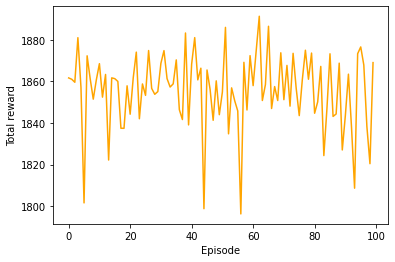

In [67]:
plt.plot(list_rewards, 'orange')
plt.ylabel('Total reward')
plt.xlabel('Episode')

Text(0.5, 0, 'Episode')

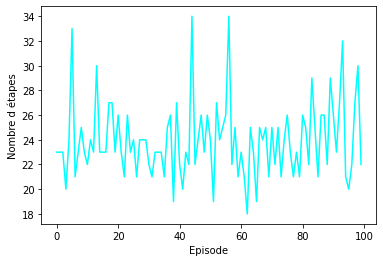

In [68]:
plt.plot(list_steps, 'cyan')
plt.ylabel('Nombre d étapes')
plt.xlabel('Episode')

In [45]:
Q

array([[ 8.70946459e+02,  7.64242117e-01,  6.23555044e+02,
         1.03738536e+03,  3.65464363e-02,  6.17669409e-01,
         5.07824931e+02,  4.33041263e+02,  7.60005165e-01,
         4.42664164e+02],
       [-2.87849500e+00,  4.92655314e-01,  4.92687935e-01,
         1.42313257e-01,  1.66919004e-03,  4.52173614e-01,
         7.40518720e-01,  7.70367789e+02,  3.80146292e-01,
         6.68378540e+02],
       [-2.66862648e+00, -2.82538000e+00,  8.03138788e-01,
         5.92175075e+02,  1.10755619e+03,  3.44255823e+02,
         3.50282099e+02, -2.91353704e+00,  7.03993310e+02,
         5.19355654e-01],
       [-4.22425994e+00,  3.29159209e+02,  5.94361616e+02,
         9.09126757e+02,  1.29100596e+03,  9.09408096e-01,
         9.46034135e-01,  7.14648085e+02,  5.81440061e-02,
         3.20573543e+02],
       [ 8.48324675e+02, -3.09888784e+00,  6.39201499e+02,
         7.57232206e+02,  1.44417723e+03,  1.27676905e+03,
         5.55704083e+02,  6.65873530e+02,  6.18609146e+02,
         5.